In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import numpy as np

sns.set_theme(style="whitegrid")
sns.set_context('paper')

pd.set_option('display.max_rows', 500)

In [2]:
# timestamp,program,flag,return_code,execution_time,pkg_energy,dram_energy,user_time,sys_time,total_time,cpu_percent,avg_text,avg_data,peak_rss,inputs,outputs,minor_pagefaults,major_pagefaults,swaps,alloc_mem,reclaimed_mem,rts_mem,total_gcs,minor_gcs,major_gcs,avg_mem,max_mem,n_samples,init_cpu,init_sys,mut_cpu,mut_sys,total_gc_cpu,total_gc_sys,minor_gc_cpu,minor_gc_sys,major_gc_cpu,major_gc_sys,balance
data_files = [
    '../data/results_45_1.csv',
    '../data/results_45_2.csv',
    # '../data/results_55_1.csv',
    # '../data/results_55_2.csv',
    # '../data/results_65_1.csv',
    # '../data/results_65_2.csv'
]

df = pd.concat(map(lambda file: pd.read_csv(file), data_files))
df['total_energy'] = df['pkg_energy'] + df['dram_energy']
display(df.head(5))

progs = df['program'].unique()
print(f"Programs ({len(progs)}): {progs}")
flags = df['flag'].unique()[1:]
print(f"Flags ({len(flags)}): {flags}")

,timestamp,program,flag,return_code,execution_time,pkg_energy,dram_energy,user_time,sys_time,total_time,...,mut_cpu,mut_sys,total_gc_cpu,total_gc_sys,minor_gc_cpu,minor_gc_sys,major_gc_cpu,major_gc_sys,balance,total_energy
0,1683221035,circsim,-O2,0,245286.912,1602169.0,52734.0,0.21,0.00,0.22,...,0.118,0.118,0.101,0.101,0.093,0.093,0.008,0.008,1,1654903.0
1,1683221036,circsim,-O2,0,237353.362,1583614.0,52795.0,0.21,0.00,0.21,...,0.118,0.118,0.097,0.098,0.089,0.090,0.008,0.008,1,1636409.0
2,1683221042,circsim,-O2,0,238780.570,1529782.0,48157.0,0.19,0.02,0.21,...,0.117,0.116,0.097,0.098,0.090,0.090,0.007,0.007,1,1577939.0
3,1683221054,circsim,-O2,0,241376.445,1528561.0,48401.0,0.21,0.00,0.21,...,0.119,0.118,0.098,0.099,0.090,0.091,0.008,0.008,1,1576962.0
4,1683221066,circsim,-O2,0,244602.692,1515926.0,49377.0,0.20,0.02,0.22,...,0.120,0.120,0.100,0.100,0.092,0.092,0.008,0.008,1,1565303.0


Programs (18): ['circsim' 'hash' 'bernouilli' 'integrate' 'coins' 'queens' 'anna' 'fluid'
 'binary-trees' 'pidigits' 'callback001' 'chan' 'power' 'treejoin'
 'fannkuch-redux' 'n-body' 'reverse-complement' 'spectral-norm']
Flags (26): ['-fno-case-merge' '-fno-case-folding' '-fno-call-arity'
 '-fno-exitification' '-fno-cmm-elim-common-blocks' '-fno-cmm-sink'
 '-fno-block-layout-cfg' '-fno-cpr-anal' '-fno-cse' '-fno-stg-cse'
 '-fno-dmd-tx-dict-sel' '-fno-do-eta-reduction'
 '-fno-do-lambda-eta-expansion' '-fno-float-in' '-fno-full-laziness'
 '-fno-ignore-asserts' '-fno-loopification' '-fno-specialise'
 '-fno-solve-constant-dicts' '-fno-stg-lift-lams' '-fno-strictness'
 '-fno-unbox-small-strict-fields' '-fno-spec-constr' '-fno-liberate-case'
 '-funfolding-use-threshold=40' '-funfolding-use-threshold=160']


## Correlation between `*_energy` and `execution_time`

In [4]:
x, y = 'total_energy', 'execution_time'

fig = px.scatter(df, x=x, y=y, color='program')
fig.show()

corr, pvalue = stats.spearmanr(df[x], df[y])
print(f'{corr:.4f} (p = {pvalue:.4f})')

0.9856 (p = 0.0000)


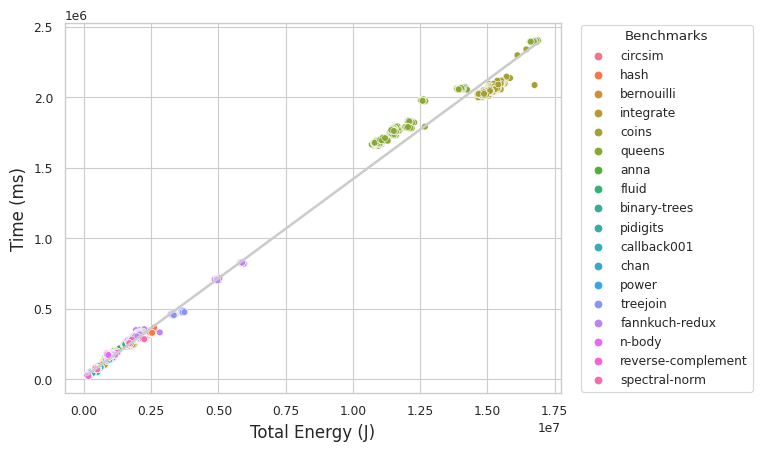

In [126]:
ax = sns.scatterplot(df, x=x, y=y, hue='program')
sns.regplot(df, x=x, y=y,            
            scatter_kws = {"color": "black", "alpha": 0.0},
            line_kws = {"color": "#cbcbcb"},
            ci = 99)
plt.legend(loc="center right", bbox_to_anchor=(1.40, 0.5), ncol=1, title='Benchmarks')
ax.set_xlabel("Total Energy (J)", fontsize=12)
ax.set_ylabel("Time (ms)", fontsize=12)

# plt.show()
plt.savefig(f"../charts/45_time_energy_correlation.pdf", bbox_inches='tight')

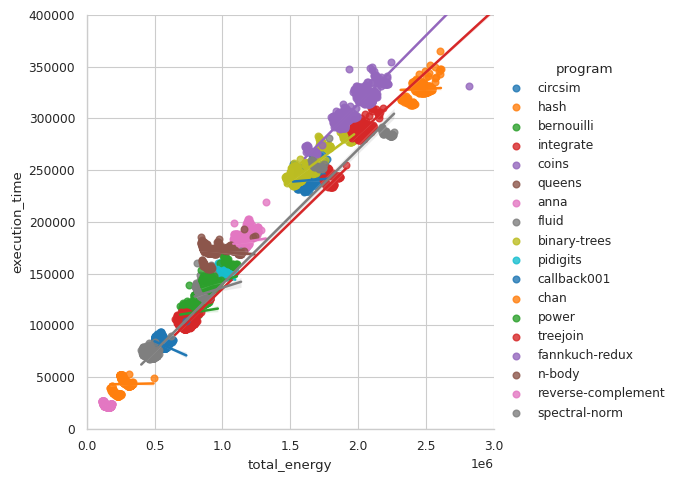

In [19]:
ax = sns.lmplot(df, x=x, y=y, hue='program', palette=sns.color_palette("tab10"))
plt.ylim(0,.4e6)
plt.xlim(0,3e6)
plt.show()

In [129]:
flags = df['flag'].unique()
x, y = 'total_energy', 'execution_time'
corr_df = []

for prog in progs:
    for flag in flags:
        corr, pvalue = stats.spearmanr(df[(df["program"] == prog) & (df["flag"] == flag)][x], df[(df["program"] == prog) & (df["flag"] == flag)][y])
        
        corr_df.append([prog, flag, corr, pvalue]) 

corr_df = pd.DataFrame(corr_df, columns=['program', 'flag', 'coef', 'pvalue'])
# corr_df

# TODO: when pvalue > 0.05 make square blank
# TODO: custom cmap (positive -> green, negative -> red)
# TODO: label relations (pl paper)
pivot = corr_df.pivot_table(index='flag', columns='program', values='pvalue', sort=False).values
labels = list(map(lambda i: list(map(lambda x: '⨯' if float(x) > 0.05 else ' ', i)), pivot))

/tmp/ipykernel_3131709/319514337.py:38: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



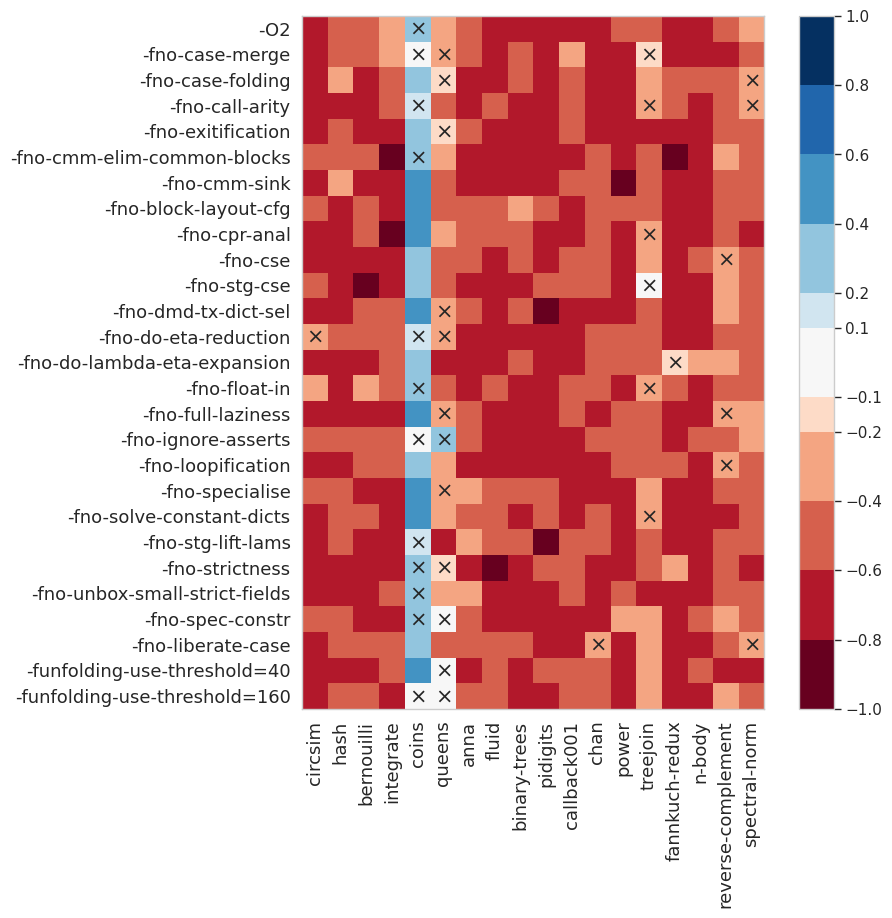

In [130]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm


fig, ax = plt.subplots(figsize=(9, 9))
# fig.subplots_adjust(bottom=0.5)

# define the color map
bounds = [-1, -.8, -.6, -.4, -.2, -.1, .1, .2, .4, .6, .8, 1]
colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']

cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# plot heatmap with `imshow`
cb = ax.imshow(
    corr_df.pivot_table(index='flag', columns='program', values='coef', sort=False),
    cmap=cmap,
    norm=norm,
    )
ax.set_xticks(np.arange(len(progs)))
ax.set_xticklabels(progs, rotation=90, fontsize=13)

ax.set_yticks(np.arange(len(flags)))
ax.set_yticklabels(flags, fontsize=13)
plt.grid(None)

for (j, i), label in np.ndenumerate(labels):
    ax.text(i, j, label, ha='center', va='center', fontsize=15)

# plot colorbar
cb2 = plt.colorbar(cb,
    ticks=bounds,
    spacing='proportional',
    orientation='vertical')
cb2.ax.tick_params(labelsize=11)
# cb2.set_label('Discrete intervals, some other units')
fig.show()
plt.savefig('../charts/time_energy_corr_heat.pdf', bbox_inches='tight')

<AxesSubplot: xlabel='total_energy', ylabel='execution_time'>

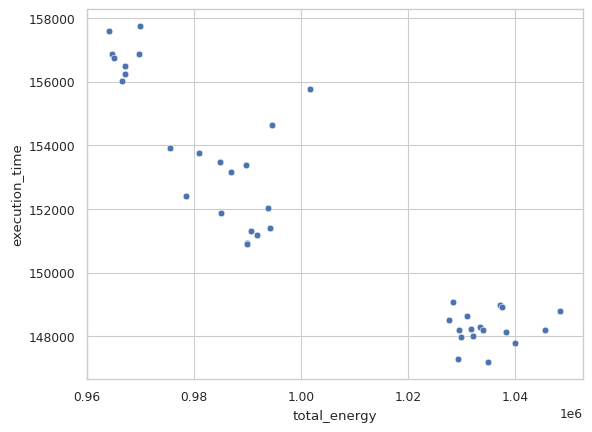

In [134]:
sns.scatterplot(df[(df['flag'] == '-fno-strictness') & (df['program'] == 'fluid')], x=x, y=y)

In [5]:
x, y = 'pkg_energy', 'execution_time'

fig = px.scatter(df, x=x, y=y, color='program')
fig.show()

corr, pvalue = stats.spearmanr(df[x], df[y])
print(f'{corr:.4f} (p = {pvalue:.4f})')

0.9775 (p = 0.0000)


In [6]:
x, y = 'dram_energy', 'execution_time'

fig = px.scatter(df, x=x, y=y, color='program')
fig.show()

corr, pvalue = stats.spearmanr(df[x], df[y])
print(f'{corr:.4f} (p = {pvalue:.4f})')

0.9661 (p = 0.0000)


___

## Correlation between `pkg_energy` and `dram_energy`

In [35]:
x, y = 'pkg_energy', 'dram_energy'

fig = px.scatter(df, x=x, y=y, color='program')
fig.show()

corr, pvalue = stats.spearmanr(df[x], df[y])
print(f'{corr:.4f} (p = {pvalue:.4f})')

0.9600 (p = 0.0000)
